### Decision Tree Regressor
#### Problem Statement: Build a model that predicts the Power Engery generated by the powerplant by taking Atmospheric pressure,temperate, vaccum and humidity into consideration
##### Step1: Data Gathering

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
path=r'https://raw.githubusercontent.com/sindhura-nk/Datasets/refs/heads/main/PowerPlant.csv'
df= pd.read_csv(path)
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


### Perform data quality checks

In [3]:
df.shape

(9568, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [5]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

* AT: Atmospheric Temperature
* V : Vaccum
* AP: Atmospheric Pressure
* RH: Relative Humidity
* PE: Power Energy

In [6]:
# check for duplicated information
df.duplicated().sum()

np.int64(41)

In [7]:
# drop the duplciates
df=df.drop_duplicates()

In [8]:
df.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

#### Separate X and Y features
* X: All the features except PE
* Y: PE - power energy

In [9]:
X=df.drop(columns=['PE'])
Y =df[['PE']]

In [10]:
X.head()

,AT,V,AP,RH
0,8.34,40.77,1010.84,90.01
1,23.64,58.49,1011.40,74.20
2,29.74,56.90,1007.15,41.91
3,19.07,49.69,1007.22,76.79
4,11.80,40.66,1017.13,97.20


In [11]:
Y.head()

,PE
0,480.48
1,445.75
2,438.76
3,453.09
4,464.43


### Data cleaning and Data preprocessing(Feature scaling)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# create pipeline
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
).set_output(transform='pandas')

X_pre = num_pipe.fit_transform(X)

X_pre.head()

,AT,V,AP,RH
0,-1.520448,-1.066041,-0.403535,1.141599
1,0.534897,0.330813,-0.309262,0.059223
2,1.354348,0.205475,-1.024725,-2.151400
3,-0.079020,-0.362884,-1.012941,0.236538
4,-1.055645,-1.074713,0.655349,1.633837


## Separate the data into training and testing

In [13]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X_pre,Y,train_size=0.8,random_state=21)

In [14]:

print(xtrain.shape)
print(xtest.shape)

(7621, 4)
(1906, 4)


## Build the model

In [15]:

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=3,
    min_samples_split=8,
    criterion='squared_error'
)

model.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=3, min_samples_split=8)

In [17]:
model.score(xtrain,ytrain)

0.9267218590737054

In [18]:
model.score(xtest,ytest)

0.927371587040563

## Hyperparameter tuning

In [19]:
params = {
    'max_depth':[2,3,4,5,6,7],
    'min_samples_split':[1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[2,3,4,5,6],
    'criterion':['squared_error','absolute_error']
}

In [20]:
from sklearn.model_selection import RandomizedSearchCV
base_model = DecisionTreeRegressor()
gscv = RandomizedSearchCV(estimator=base_model,param_distributions=params,cv=3,scoring='r2')
gscv.fit(xtrain,ytrain)

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(),
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [2, 3, 4, 5, 6],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10]},
                   scoring='r2')

In [21]:
gscv.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_depth': 7,
 'criterion': 'absolute_error'}

In [22]:
gscv.best_score_

np.float64(0.9363334326296107)

In [23]:
best_dtr = gscv.best_estimator_
best_dtr

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=3, min_samples_split=10)

## Model Evaluation

In [24]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

ypreds_tr = best_dtr.predict(xtrain)
ypreds_te = best_dtr.predict(xtest)

mse_tr = mean_squared_error(ytrain,ypreds_tr)
mae_tr = mean_absolute_error(ytrain,ypreds_tr)
rmse_tr = mse_tr**(1/2)
r2_tr = r2_score(ytrain,ypreds_tr)

print("==========================")
print("Training Scores")
print(f"MSE:{mse_tr}")
print(f"RMSE:{rmse_tr}")
print(f"MAE:{mae_tr}")
print(f"R2:{r2_tr}")


mse_te = mean_squared_error(ytest,ypreds_te)
mae_te = mean_absolute_error(ytest,ypreds_te)
rmse_te = mse_te**(1/2)
r2_te = r2_score(ytest,ypreds_te)

print("==========================")
print("Testing Scores")
print(f"MSE:{mse_te}")
print(f"RMSE:{rmse_te}")
print(f"MAE:{mae_te}")
print(f"R2:{r2_te}")

Training Scores
MSE:15.393122352709618
RMSE:3.9234069828032903
MAE:2.8425862747670907
R2:0.9469315502841947
Testing Scores
MSE:17.453345264952773
RMSE:4.177720103711207
MAE:3.138145330535152
R2:0.9400747228549347


## Decision Tree Plotting

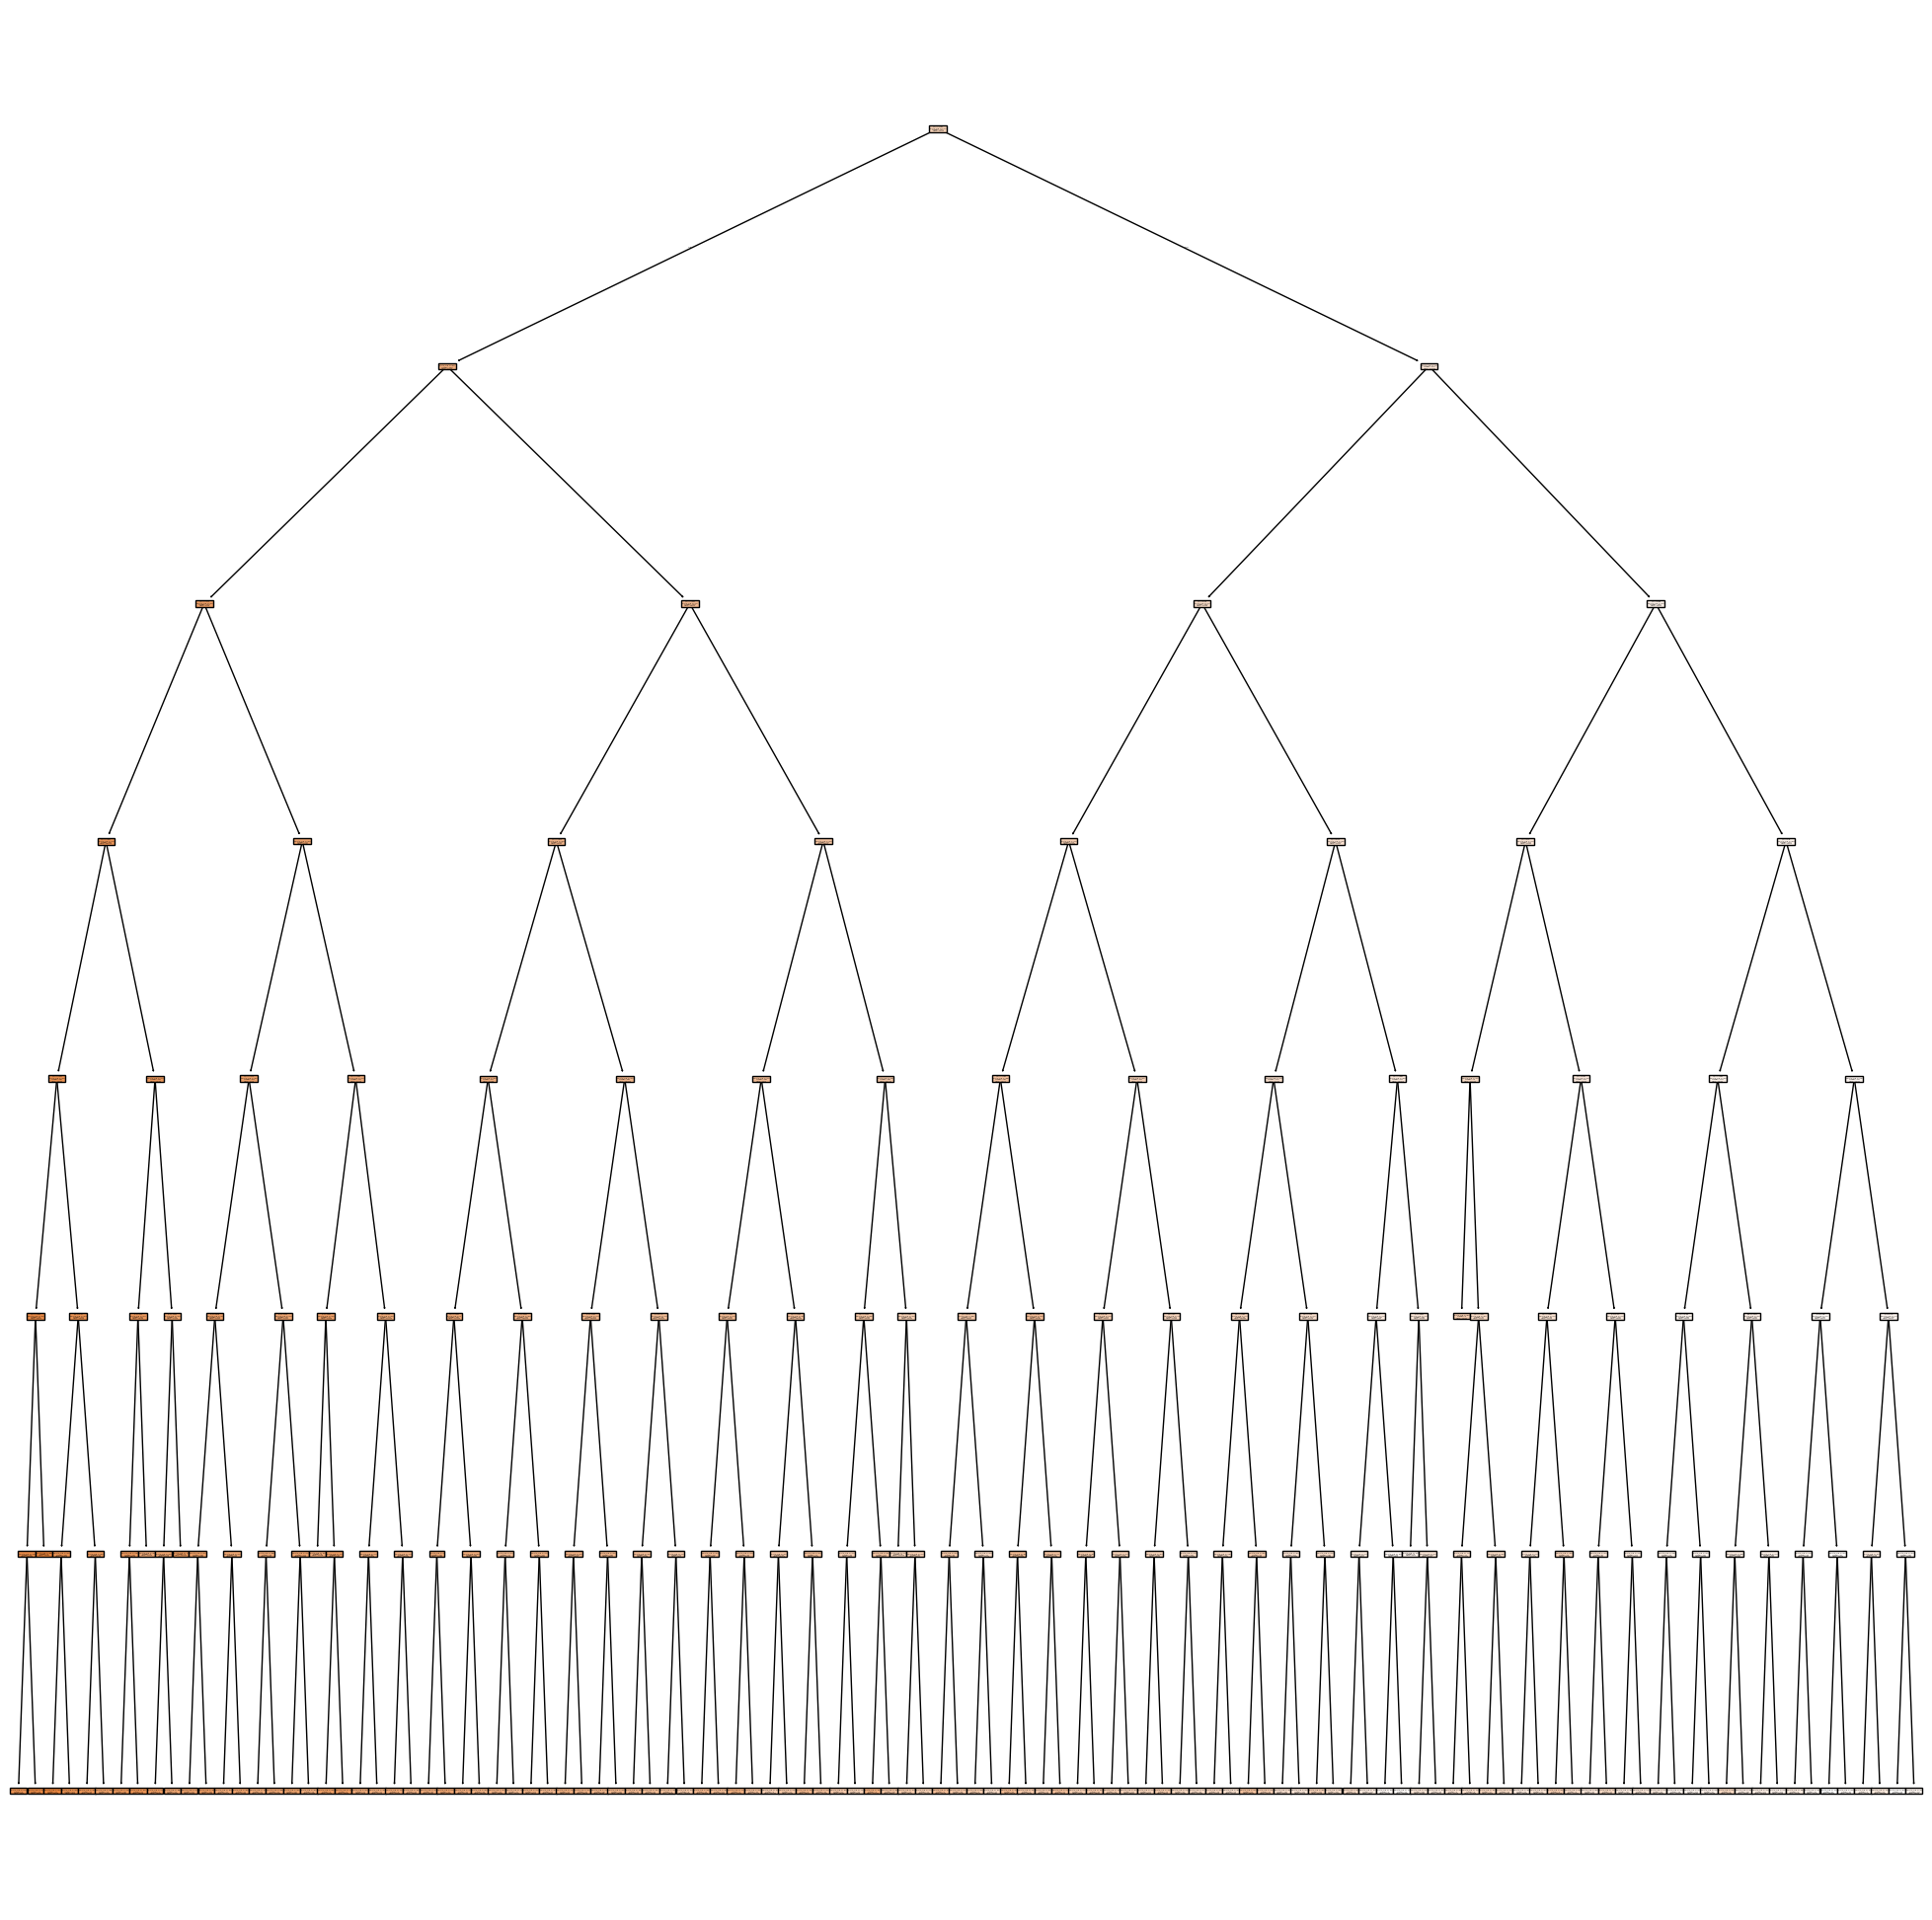

In [25]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fea_names = xtrain.columns
plt.figure(figsize=(25,25))
plot_tree(best_dtr,feature_names=fea_names,filled=True)
plt.show()

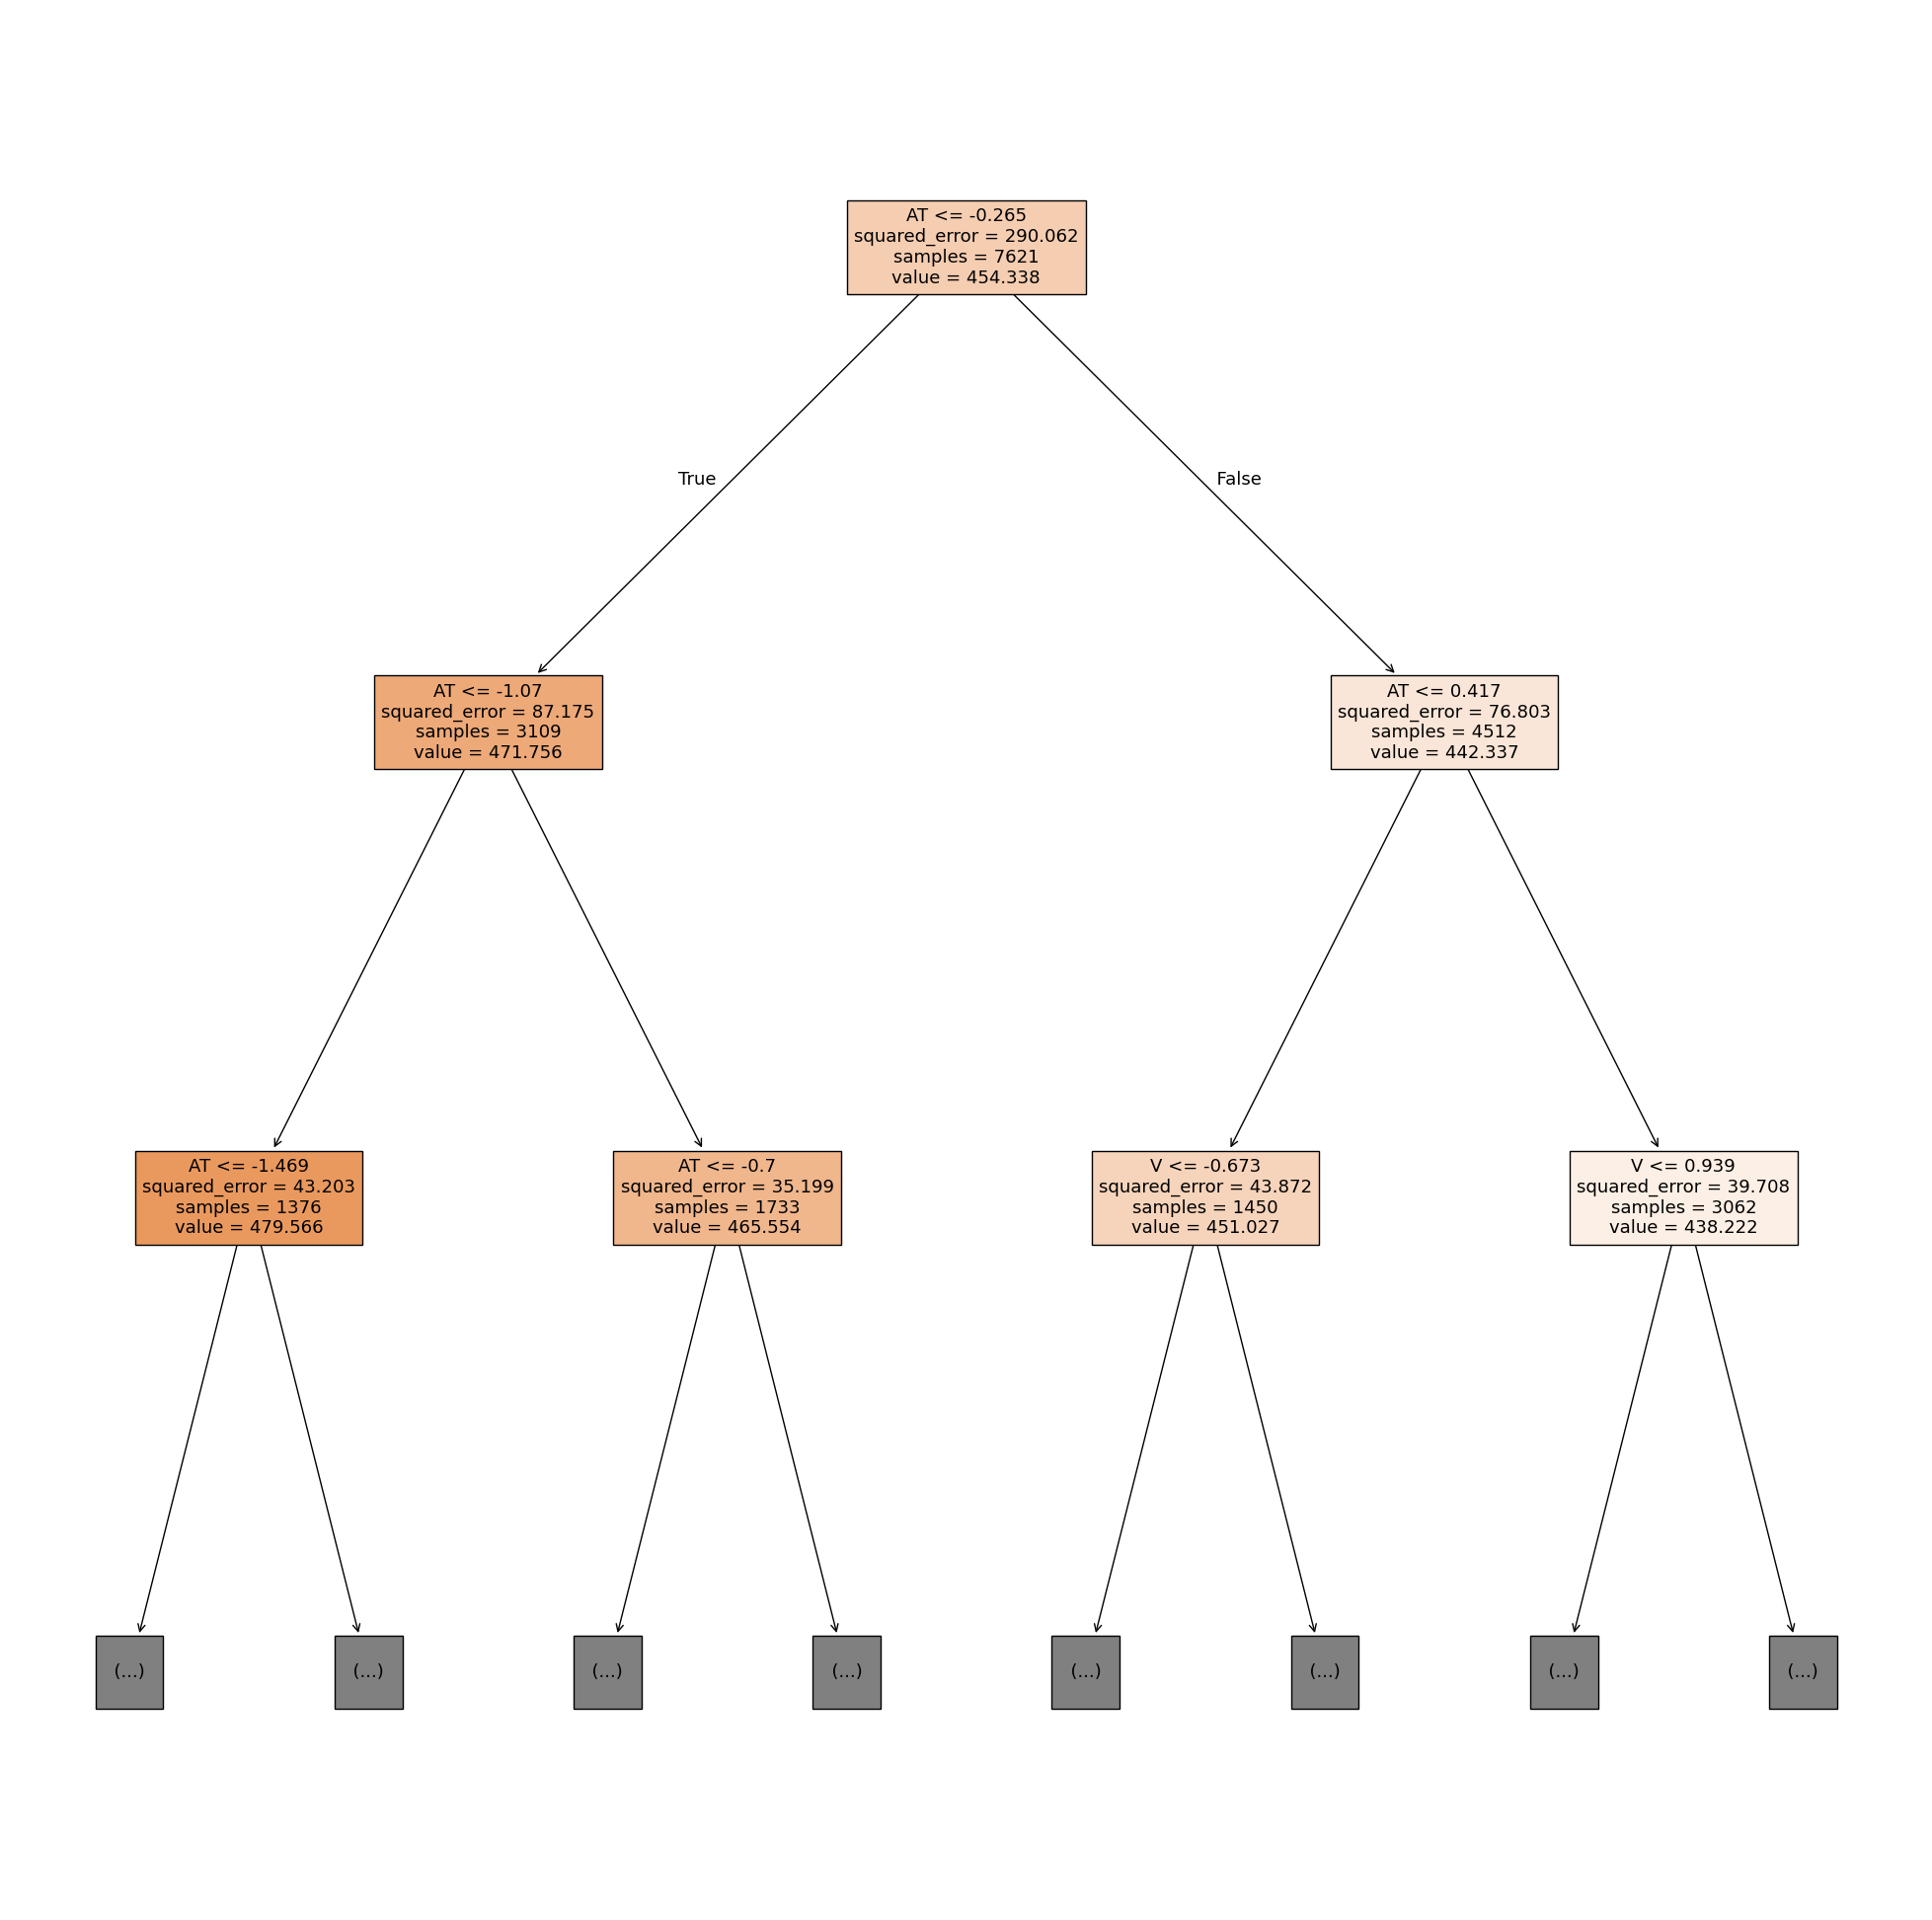

In [28]:
plt.figure(figsize=(25,25))
plot_tree(best_dtr,feature_names=fea_names,filled=True,max_depth=2)
plt.show()

##### R2 score is above 80% in both training and testing. We can finalise this model for out of sample predictions

In [26]:

import joblib
joblib.dump(num_pipe,'pre.joblib2')
joblib.dump(best_dtr,'model.joblib2')

['model.joblib2']

In [27]:
pre2 = joblib.load('pre.joblib2')
m2 = joblib.load('model.joblib2')

In [28]:
pre2

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [29]:
m2

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=3, min_samples_split=10)

In [30]:
path3 = r"https://raw.githubusercontent.com/sindhura-nk/Datasets/refs/heads/main/PowerPlantTest.csv"

xnew = pd.read_csv(path3)
xnew.head()

,AT,V,AP,RH
0,25,51.5,1000.1,57.0
1,32,41.0,1051.1,80.0
2,28,NaN,1010.2,NaN


In [31]:
xnew_pre = pre2.transform(xnew)
xnew_pre

,AT,V,AP,RH
0,0.717594,-0.220203,-2.211551,-1.118316
1,1.657948,-1.047911,6.373998,0.456299
2,1.120603,-0.174482,-0.511275,0.113992


In [32]:
pe_predictions = m2.predict(xnew_pre)
pe_predictions = pe_predictions.round(2)

In [33]:
pe_predictions

array([443.13, 434.1 , 440.89])

In [34]:
xnew['PE_Predicted'] = pe_predictions
xnew

,AT,V,AP,RH,PE_Predicted
0,25,51.5,1000.1,57.0,443.13
1,32,41.0,1051.1,80.0,434.10
2,28,NaN,1010.2,NaN,440.89


In [35]:
# to save the results
xnew.to_csv("PE_predictions.csv",index=False)